# Validate Dynast's splicing quantification

This notebook will validate the splicing quantification (spliced, unspliced transcripts) produced by Dynast with that produced by [velocyto](http://velocyto.org/).

In [448]:
import glob
import warnings

import anndata
import igraph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import velocyto as vcy
from matplotlib.lines import Line2D
from numpy_groupies import aggregate, aggregate_np
from scipy import sparse
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# R wrappers
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

plt.style.use('../figures.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

In [527]:
with open('data/accessions.txt', 'r') as f:
    accessions = [line.strip() for line in f]
    
cell_list = pd.read_csv('data/cells.csv', names=['sample', 'barcode', 'cluster'])

accession_samples = {
    'SRR6470906': '10X_17_029',
    'SRR6470907': '10X_17_028',
}
dynast_adatas = {}
velocyto_adatas = {}
for accession in accessions:
    looms = glob.glob(f'velocyto/{accession}/run/*.loom')
    assert len(looms) == 1
    velocyto_adata = anndata.read_loom(looms[0])
    velocyto_adata.var_names.name = 'gene_name'
    velocyto_adata.var = velocyto_adata.var.reset_index().set_index('Accession')
    velocyto_adata.obs_names = velocyto_adata.obs_names.str.split(':').str[1].str[:-1]
    
    dynast_adata = anndata.read(f'dynast/{accession}/count/adata.h5ad')
    
    accession_cell_list = cell_list[cell_list['sample'] == accession_samples[accession]]
    
    # Make sure both have the same cells and genes
    barcodes = np.intersect1d(velocyto_adata.obs_names, dynast_adata.obs_names)
    barcodes = sorted(np.intersect1d(barcodes, accession_cell_list['barcode']))
    genes = sorted(np.intersect1d(velocyto_adata.var_names, dynast_adata.var_names))

    velocyto_adatas[accession] = velocyto_adata[barcodes, genes].copy()
    dynast_adatas[accession] = dynast_adata[barcodes, genes].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Comparisons

Compare the spliced, unspliced counts between the two pipelines.

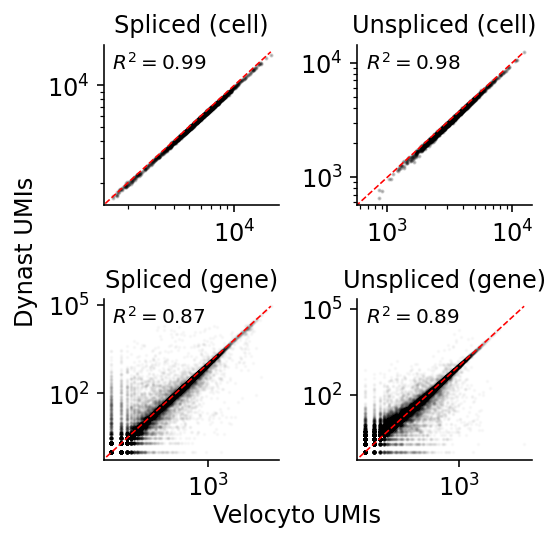

In [555]:
def plot_correlation(x, y, alpha, ax):
    r2 = r2_score(np.log1p(x), np.log1p(y))
    
    ax.scatter(x, y, s=1, c='black', alpha=alpha)
    high = max(max(x), max(y))
    ax.plot([0, high], [0, high], c='red', linestyle='--', linewidth=0.8)
    ax.text(0.05, 0.85, f'$R^2 = {r2:.2f}$', fontsize=10, transform=ax.transAxes)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    xlow, xhigh = ax.get_xlim()
    ylow, yhigh = ax.get_ylim()
    lim_low = min(xlow, ylow)
    lim_high = max(xhigh, yhigh)
    ax.set_xlim(lim_low, lim_high)
    ax.set_ylim(lim_low, lim_high)

velocyto_cell_spliced = []
velocyto_cell_unspliced = []
dynast_cell_spliced = []
dynast_cell_unspliced = []

velocyto_gene_spliced = []
velocyto_gene_unspliced = []
dynast_gene_spliced = []
dynast_gene_unspliced = []
for accession in accessions:
    velocyto_adata = velocyto_adatas[accession]
    dynast_adata = dynast_adatas[accession]
    
    velocyto_cell_spliced.extend(velocyto_adata.layers['spliced'].sum(axis=1).A.flatten())
    dynast_cell_spliced.extend(dynast_adata.layers['spliced'].sum(axis=1).A.flatten())
    
    velocyto_cell_unspliced.extend(velocyto_adata.layers['unspliced'].sum(axis=1).A.flatten())
    dynast_cell_unspliced.extend(dynast_adata.layers['unspliced'].sum(axis=1).A.flatten())
    
    velocyto_gene_spliced.extend(velocyto_adata.layers['spliced'].sum(axis=0).A.flatten())
    dynast_gene_spliced.extend(dynast_adata.layers['spliced'].sum(axis=0).A.flatten())
    
    velocyto_gene_unspliced.extend(velocyto_adata.layers['unspliced'].sum(axis=0).A.flatten())
    dynast_gene_unspliced.extend(dynast_adata.layers['unspliced'].sum(axis=0).A.flatten())
    
fig, axes = plt.subplots(figsize=(4, 4), ncols=2, nrows=2, tight_layout=True)
plot_correlation(velocyto_cell_spliced, dynast_cell_spliced, 0.2, axes[0,0])
axes[0, 0].set_title('Spliced (cell)')

plot_correlation(velocyto_cell_unspliced, dynast_cell_unspliced, 0.2, axes[0,1])
axes[0, 1].set_title('Unspliced (cell)')

plot_correlation(velocyto_gene_spliced, dynast_gene_spliced, 0.02, axes[1,0])
axes[1, 0].set_title('Spliced (gene)')

plot_correlation(velocyto_gene_unspliced, dynast_gene_unspliced, 0.02, axes[1,1])
axes[1, 1].set_title('Unspliced (gene)')

fig.supylabel('Dynast UMIs', x=0.06, y=0.55)
fig.supxlabel('Velocyto UMIs', y=0.07, x=0.55)

fig.savefig('figures/velocyto_umis.png', bbox_inches='tight', dpi=300)

## RNA velocity

Generate RNA velocity flows similar to that was done in the RNA velocity paper [Figure 4](https://www.nature.com/articles/s41586-018-0414-6/figures/4).

In [529]:
sample_accessions = {
    '10X_17_029': 'SRR6470906',
    '10X_17_028': 'SRR6470907',
}

# Clean up velocyto anndata
velocyto_adata = anndata.AnnData.concatenate(
    *list(velocyto_adatas.values()),
    batch_key='accession', batch_categories=velocyto_adatas.keys()
)
velocyto_adata.obs.drop(columns='accession', inplace=True)
velocyto_adata.var.drop(columns=[
    'Chromosome', 'End', 'Start', 'Strand'
], inplace=True)
velocyto_adata.obs['CellID'] = velocyto_adata.obs_names
velocyto_adata.obs['Clusters'] = cell_list.set_index(
    cell_list['barcode'] + '-' +  cell_list['sample'].map(sample_accessions)
).loc[velocyto_adata.obs_names, 'cluster']
velocyto_adata.var = velocyto_adata.var.reset_index().set_index('gene_name')
velocyto_adata.var_names.name = None
del velocyto_adata.layers['matrix']

# Clean up Dynast anndata
dynast_adata = anndata.AnnData.concatenate(
    *list(dynast_adatas.values()),
    batch_key='accession', batch_categories=dynast_adatas.keys()
)
dynast_adata.obs.drop(columns='accession', inplace=True)
dynast_adata.obs['CellID'] = dynast_adata.obs_names
dynast_adata.obs['Clusters'] = cell_list.set_index(
    cell_list['barcode'] + '-' +  cell_list['sample'].map(sample_accessions)
).loc[dynast_adata.obs_names, 'cluster']
dynast_adata.var = dynast_adata.var.reset_index().set_index('gene_name')
dynast_adata.var_names.name = None
dynast_adata.var_names = dynast_adata.var_names.astype(str)
dynast_adata.var.rename(columns={'gene_id': 'Accession'}, inplace=True)
dynast_adata.X = velocyto_adata.layers['spliced'].copy()
for obsm in list(dynast_adata.obsm.keys()):
    del dynast_adata.obsm[obsm]
for layer in list(dynast_adata.layers.keys()):
    if layer not in ('spliced', 'unspliced', 'ambiguous'):
        del dynast_adata.layers[layer]
    else:
        # Match data types of velocyto output
        dynast_adata.layers[layer] = dynast_adata.layers[layer].astype(velocyto_adata.layers[layer].dtype)

velocyto_adata.write_loom('velocyto/velocyto.loom')
dynast_adata.write_loom('dynast/dynast.loom')

In [530]:
def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)

    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict="warn")

    #call the function
    fit1 = princurve.principal_curve(xr)

    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )

    if pca:
        results.PCs = np.array(xr) #only the used components

    return results

def run_velocyto(vlm):
    """Helper function to run velocyto on a VelocytoLoom object.
    https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb
    """
    labels = vlm.ca["Clusters"]
    manual_annotation = {str(i):[i] for i in labels}
    annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
    clusters = np.array([annotation_dict[i] for i in labels])
    colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
    vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})
    
    vlm.normalize("S", size=True, log=False)
    vlm.normalize("U", size=True, log=False)
    
    vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
    vlm.filter_genes(by_detection_levels=True)
    
    vlm.score_cv_vs_mean(2000, plot=False, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
    vlm.filter_genes(by_cv_vs_mean=True)
    
    vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
    vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
    vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
    vlm.normalize_by_total(min_perc_U=0.5)
    vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)
    
    vlm.perform_PCA()
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    vlm.pcs[:,1] *= -1 # flip for consistency with previous version
    
    nn = NearestNeighbors(n_neighbors=50)
    nn.fit(vlm.pcs[:,:4])
    knn_pca = nn.kneighbors_graph(mode='distance')
    knn_pca = knn_pca.tocoo()
    G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
    VxCl = G.community_multilevel(return_levels=False, weights="weight")
    labels = np.array(VxCl.membership)
    
    pc_obj = principal_curve(vlm.pcs[:,:4], False)
    pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
    labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]
    
    manual_annotation = {str(i):[i] for i in labels}
    annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
    clusters = np.array([annotation_dict[i] for i in labels])
    colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
    vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})
    
    k = 550
    vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                       b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                       b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))
    vlm.normalize_median()
    vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)
    
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift()
    vlm.extrapolate_cell_at_t(delta_t=1)
    
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)
    
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
    
    vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)
    return vlm, pc_obj

In [531]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    velocyto_loom, velocyto_pc = run_velocyto(vcy.VelocytoLoom('velocyto/velocyto.loom'))
    dynast_loom, dynast_pc = run_velocyto(vcy.VelocytoLoom('dynast/dynast.loom'))

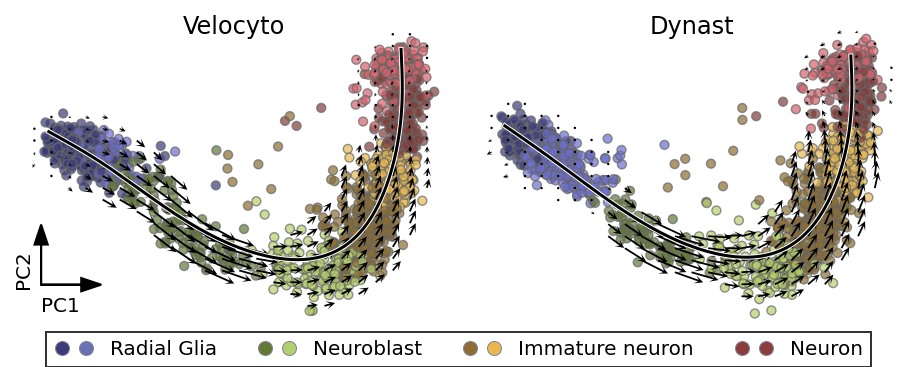

In [556]:
fig, axes = plt.subplots(ncols=2, figsize=(6.5, 2.5), tight_layout=True)
plt.sca(axes[0])
velocyto_loom.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":20, "rasterized":False},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
axes[0].plot(velocyto_pc.projections[velocyto_pc.ixsort,0], velocyto_pc.projections[velocyto_pc.ixsort,1], c="w", lw=2.5, zorder=1000000)
axes[0].plot(velocyto_pc.projections[velocyto_pc.ixsort,0], velocyto_pc.projections[velocyto_pc.ixsort,1], c="k", lw=1.5, zorder=2000000)
axes[0].invert_xaxis()
axes[0].axis("off")
axes[0].axis("equal")
xlow, xhigh = axes[0].get_xlim()
ylow, yhigh = axes[0].get_ylim()
axes[0].arrow(xlow - 2, ylow + 3, 0, 3, head_width=1, color='black')
axes[0].arrow(xlow - 2, ylow + 3, -3, 0, head_width=1, color='black')
axes[0].text(xlow - 2, ylow + 1, 'PC1')
axes[0].text(xlow, ylow + 3, 'PC2', rotation=90)
axes[0].set_title('Velocyto', y=0.9)

plt.sca(axes[1])
dynast_loom.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":20, "rasterized":False},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
axes[1].plot(dynast_pc.projections[dynast_pc.ixsort,0], dynast_pc.projections[dynast_pc.ixsort,1], c="w", lw=2.5, zorder=1000000)
axes[1].plot(dynast_pc.projections[dynast_pc.ixsort,0], dynast_pc.projections[dynast_pc.ixsort,1], c="k", lw=1.5, zorder=2000000)
axes[1].invert_xaxis()
axes[1].axis("off")
axes[1].axis("equal")
axes[1].set_title('Dynast', y=0.9)

fig.legend([
    (
        Line2D([0], [0], marker='o', markerfacecolor='#3b3b79', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7),
        Line2D([0], [0], marker='o', markerfacecolor='#6871b1', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7)
    ),
    (
        Line2D([0], [0], marker='o', markerfacecolor='#647934', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7),
        Line2D([0], [0], marker='o', markerfacecolor='#b2cf6f', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7)
    ),
    (
        Line2D([0], [0], marker='o', markerfacecolor='#8d6d35', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7),
        Line2D([0], [0], marker='o', markerfacecolor='#e9b84d', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7)
    ),
    (
        Line2D([0], [0], marker='o', markerfacecolor='#8a3d3c', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7),
        Line2D([0], [0], marker='o', markerfacecolor='#8a3d3c', markeredgecolor='#83869b', markeredgewidth=0.5, color='white', markersize=7)
    ),
    
], [
    'Radial Glia', 'Neuroblast', 'Immature neuron', 'Neuron'
], handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=4, loc=(0.05, 0))

fig.savefig('figures/velocyto_projection.png', bbox_inches='tight', dpi=300)